## REST API

In this section we want to extract the nobel prize motivations and present the most frequently used words in a wordcloud. We start by providing the link to the designated location found on the API page from 'https://www.nobelprize.org/organization/developer-zone-2/'. We then filter by the parameters "phy" for physics and "json" for the format and retrieve the data. 

In [1]:
import requests

# We start by accessing the url utilizing the request function
url = "https://api.nobelprize.org/2.1/nobelPrizes"
parameters = {"nobelPrizeCategory": "phy", "format": "json"}
response = requests.get(url, params=parameters)

# retrieve data
data = response.json()
#print(data)


Now we move on to extract the motivations in english and filter by all default english stopwords. We start by initializing an empty array. Then we condition if the data is found and loop through all motivations and filter for english language for each laureate. We then merge all strings into one.

In [2]:
from langdetect import detect
from wordcloud import STOPWORDS
# initialze empty array
motivations = []

# if data is available 
if data:
    # get nobelPrize if available, return empty array otherwise
    for prize in data.get("nobelPrizes", []):
         # get laureate ('prize taker') if available, return empty array otherwise
        for laureate in prize.get("laureates", []):
            # if motivation is stored, retrieve it
            #motivation = laureate.get("motivation", {}).get("text", "")
            motivation = laureate.get("motivation", {}).values()  
            motivations.extend(motivation)
            motivations = [text for text in motivations if detect(text) == 'en']

# merge all motivations to one string
all_motivations = " ".join(motivations)

stopwords = set(STOPWORDS)

all_motivations = " ".join(motivations)



Finally, we create and plot our wordcloud:

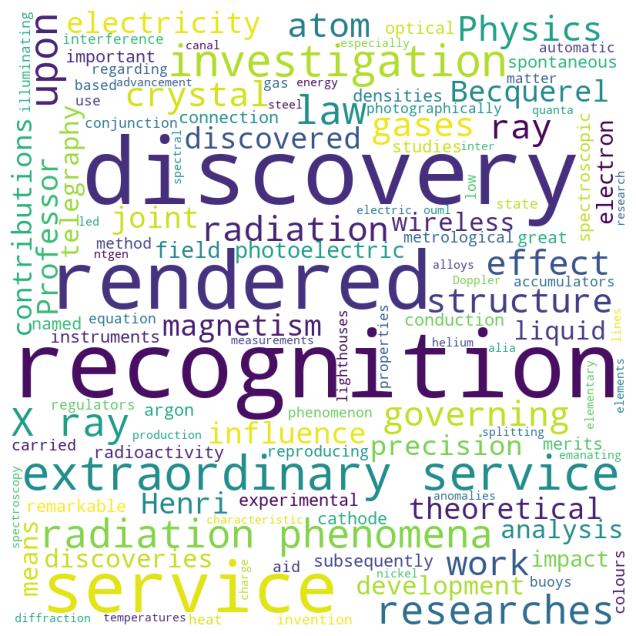

In [4]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# create the word cloud
wordcloud = WordCloud(width=800, height=800,
                      background_color='white',
                      min_font_size=10).generate(all_motivations)

# plot results
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

## Web Scraping

Now in this section we will scrape data from 'books.toscrape.com', investigate the URL, and retrieve data on 20 books from three different pages, that will total to 60 data points. We start by naming the columns of the data we want to retrieve and initializing a variable. After manually investigating 'https://books.toscrape.com' through a trial-and-error approach, I managed to extract the data. I created a loop for each page required for the 60 books by referencing the URL corresponding to the correct page and parsing the URLs. Then using BeautifulSoup I navigated to all articles under the class called 'product_pod'. From there I created a loop to go through all books under the class 'product_pod'. For each book, I extracted the title from the 'h3.a' tag, while the price and rating were found within the 'p' tag under the classes "price_color" and "star-rating" respectively. Finally, to find the Universal Product Code (UPC) I found that it was not located under 'product_pod'. By inspection it was found under a class called "table table-striped". To access it I created a detailed link to each book. Using the href in the 'h3' tag I made a GET request and parsed the response using BeautifulSoup. From there the UPC was extracted from  'tr' inside the table with the class "table table-striped". 

In [6]:
import pandas as pd
import requests
from bs4 import BeautifulSoup

# url for three pages
#https://books.toscrape.com/catalogue/page-1,2,3.html

# Column names
columns = ["upc","title", "price", "rating"]
# initilize variable 
data = []

# Loop through the first 3 pages
for page in range(1, 4):
    # retrieve and parse 
    url = f"https://books.toscrape.com/catalogue/page-{page}.html"
    response = requests.get(url)
    soup = BeautifulSoup(response.content, "html.parser")

    # Books found under class product_pod
    books = soup.find_all("article", class_="product_pod")

    for book in books:
        # retrieve title, price and rating:
        # title in h3 under a
        title = book.h3.a["title"] 
        # price found in class price_color under p
        price = book.find("p", class_="price_color").text.strip() 
        # rating found in the same line as star-rating under p
        rating_class = book.find("p", class_="star-rating")["class"]
        
        # upc cannot be found under article, instead we need to acess the detail_link 
        # via product_pod that links to href
        # link and parse 
        detail_link = "https://books.toscrape.com/catalogue/" + book.h3.a["href"]
        detail_response = requests.get(detail_link)
        detail_soup = BeautifulSoup(detail_response.content, "html.parser")
        
        # upc found under class called table table-striped inside tr
        table = detail_soup.find("table", class_="table table-striped")
        upc = table.find("tr").td.text
        # retrieve relevant data
        data.append([upc, title, price, rating_class[1]])

# Convert to dataframe
data_e = pd.DataFrame(data, columns=columns)

# filter by desired titles
data_f = data_e[data_e["title"].isin(['A Light in the Attic', 'Tipping the Velvet',
        'Soumission', 'Sharp Objects', 'Sapiens: A Brief History of Humankind'])]

data_f
#data_e.head(10)

,upc,title,price,rating
0,a897fe39b1053632,A Light in the Attic,£51.77,Three
1,90fa61229261140a,Tipping the Velvet,£53.74,One
2,6957f44c3847a760,Soumission,£50.10,One
3,e00eb4fd7b871a48,Sharp Objects,£47.82,Four
4,4165285e1663650f,Sapiens: A Brief History of Humankind,£54.23,Five


## Side Note
After using the trial and error approach I was recommended to only use the detailed link to the upc to find all information about each book. In retrospect this obviously would have been more efficient and more concise. 